In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import commons
import textwrap
import math
import os

In [2]:
# load data and ratings about open-source projects

features = set()
scores = set()
data = []
score_weights = {}

def process_used_score_value(used_value, row, score_weights):
    score_type = used_value['score']['type']
    if used_value['isNotApplicable']:
        row[score_type] = 'N/A'
    else:
        row[score_type] = used_value['value']
    if score_type not in score_weights:
        score_weights[score_type] = used_value['weight']
    elif score_weights[score_type] != used_value['weight']:
        raise Exception('Oops! Weights do not match!')

def process_vulnerability_value(used_value, row):
    row['# of vulnerabilities'] = len(used_value['vulnerabilities']['entries'])
    row['# of unpatched vulnerabilities'] = 0
    row['# of patched vulnerabilities'] = 0
    row['# of vulnerabilities without introduced date'] = 0
    row['# of vulnerabilities without fixed date'] = 0
    for entry in used_value['vulnerabilities']['entries']:
        if entry['resolution'] == 'UNPATCHED':
            row['# of unpatched vulnerabilities'] = row['# of unpatched vulnerabilities'] + 1
        elif entry['resolution'] == 'PATCHED':
            row['# of patched vulnerabilities'] = row['# of patched vulnerabilities'] + 1
        if entry['introduced'] is None:
            row['# of vulnerabilities without introduced date'] = row['# of vulnerabilities without introduced date'] + 1
        if entry['fixed'] is None:
            row['# of vulnerabilities without fixed date'] = row['# of vulnerabilities without fixed date'] + 1
        
def process_sub_scores(score_value, row, score_weights):
    for used_value in score_value['usedValues']:
        if used_value['type'] == 'ScoreValue':
            scores.add(used_value['score']['type'])
            process_used_score_value(used_value, row, score_weights)
            process_sub_scores(used_value, row, score_weights)
            continue
        
        feature = used_value['feature']['name']
        features.add(feature)
          
        if used_value['type'] == 'UnknownValue':
            row[feature] = 'unknown'
        elif used_value['type'] == 'VulnerabilitiesValue':
            process_vulnerability_value(used_value, row)
                
        elif used_value['type'] == 'IntegerValue':
            row[feature] = used_value['number']
        elif used_value['type'] == 'BooleanValue':
            row[feature] = used_value['flag']
        elif used_value['type'] == 'DateValue':
            row[feature] = used_value['date']
        elif used_value['type'] == 'LanguagesValue':
            row[feature] = used_value['languages']['elements']
        elif used_value['type'] == 'PackageManagersValue':
            row[feature] = used_value['packageManagers']['packageManagers']
        elif used_value['type'] == 'LgtmGradeValue':
            row[feature] = used_value['value']
        elif used_value['type'] == 'OwaspDependencyCheckUsageValue':
            row[feature] = used_value['value']
        elif used_value['type'] == 'SecurityReviewsValue':
            row[feature] = used_value['reviews']
        elif used_value['type'] == 'OwaspDependencyCheckCvssThresholdValue':
            # we convert the numbers to string because it's necessary
            # to draw the charts below
            row[feature] = str(used_value['number'])
        else:
            raise Exception('Unknown value type: ' + used_value['type'])
    
input_file = os.environ.get('INPUT_FILE', '../../../../../docs/oss/security/github_projects.json')
            
with open(input_file) as json_file:
    json_data = json.load(json_file)
    for json_project_data in json_data:
        row = {}
        #print(json_project_data)
        row['URL'] = 'https://github.com/' + json_project_data['organization']['name'] + '/' + json_project_data['name']
        rating_value = json_project_data['ratingValue']
        if rating_value is None:
            continue
            
        row['Label'] = rating_value['label'][1]
        
        score_value = json_project_data['ratingValue']['scoreValue']
        row['Score'] = score_value['value']
        row['Confidence'] = score_value['confidence']
        
        process_sub_scores(score_value, row, score_weights)
        
        data.append(row)
            
        
project_data = pd.DataFrame(data)
project_data.fillna('unknown', inplace = True)
project_data

,URL,Label,Score,Confidence,VulnerabilityDiscoveryAndSecurityTestingScore,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date,...,If an open-source project belongs to Eclipse Foundation,ProjectActivityScore,Number of commits in the last three months,Number of contributors in the last three months,SecurityReviewScore,Security reviews for a project,ProjectPopularityScore,Number of stars for a GitHub repository,Number of watchers for a GitHub repository,Number of projects on GitHub that use an open source project
0,https://github.com/FasterXML/jackson,BAD,2.800518,9.513678,2.0,0,0,0,0,0,...,False,0.461538,3,1,0.0,[],8.063333,6900,349,unknown
1,https://github.com/FasterXML/jackson-core,BAD,4.327183,10.000000,2.0,0,0,0,0,0,...,False,7.384615,48,1,0.0,[],10.000000,1983,153,204427
2,https://github.com/FasterXML/jackson-databind,MODERATE,5.081238,10.000000,0.0,64,0,64,64,64,...,False,10.000000,98,2,0.0,[],10.000000,2899,161,436158
3,https://github.com/GoogleChrome/lighthouse,MODERATE,5.215667,10.000000,2.0,0,0,0,0,0,...,False,10.000000,177,1,0.0,[],10.000000,23465,556,7897
4,https://github.com/apache/activemq,BAD,4.371345,9.645390,0.0,32,0,32,32,32,...,False,8.307692,45,6,0.0,[],2.602000,1942,198,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,https://github.com/spring-projects/spring-retry,GOOD,5.639265,10.000000,2.0,0,0,0,0,0,...,False,0.000000,0,0,0.0,[],10.000000,1565,105,21188
187,https://github.com/spring-projects/spring-secu...,MODERATE,5.028453,9.645390,0.0,13,0,13,13,13,...,False,10.000000,219,8,0.0,[],7.722000,6252,441,unknown
188,https://github.com/spring-projects/spring-secu...,MODERATE,5.086357,10.000000,2.0,5,0,5,5,5,...,False,0.153846,1,1,0.0,[],6.467000,4467,400,1000
189,https://github.com/spring-projects/spring-session,BAD,4.120075,9.645390,2.0,0,0,0,0,0,...,False,6.430769,38,4,0.0,[],2.170667,1644,158,unknown


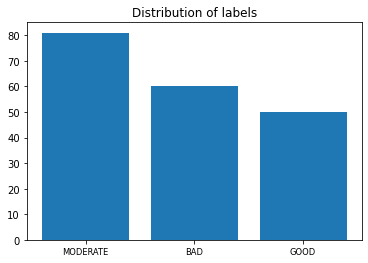

In [3]:
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('Distribution of labels')
plt.show()

<Figure size 720x720 with 0 Axes>

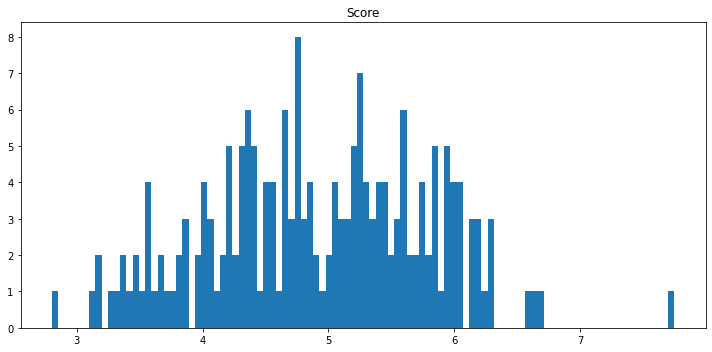

In [4]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Score'
d = df[column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

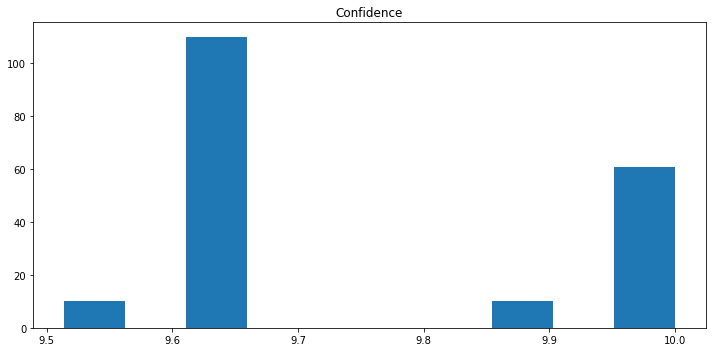

In [5]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'Confidence'
d = df[column]
ax.hist(d, histtype='bar', bins=10)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

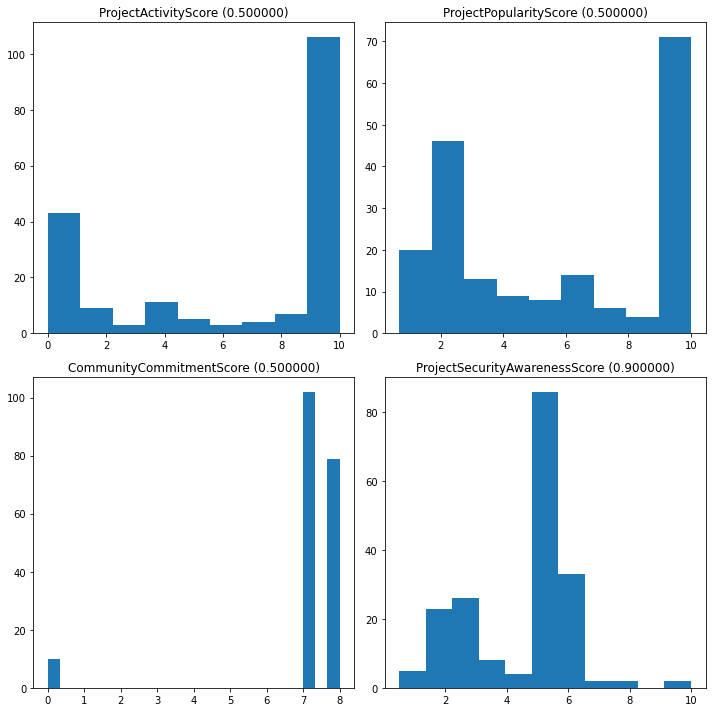

In [6]:
df = project_data[['ProjectActivityScore', 'ProjectPopularityScore', 
                   'CommunityCommitmentScore', 'ProjectSecurityAwarenessScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[column]
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

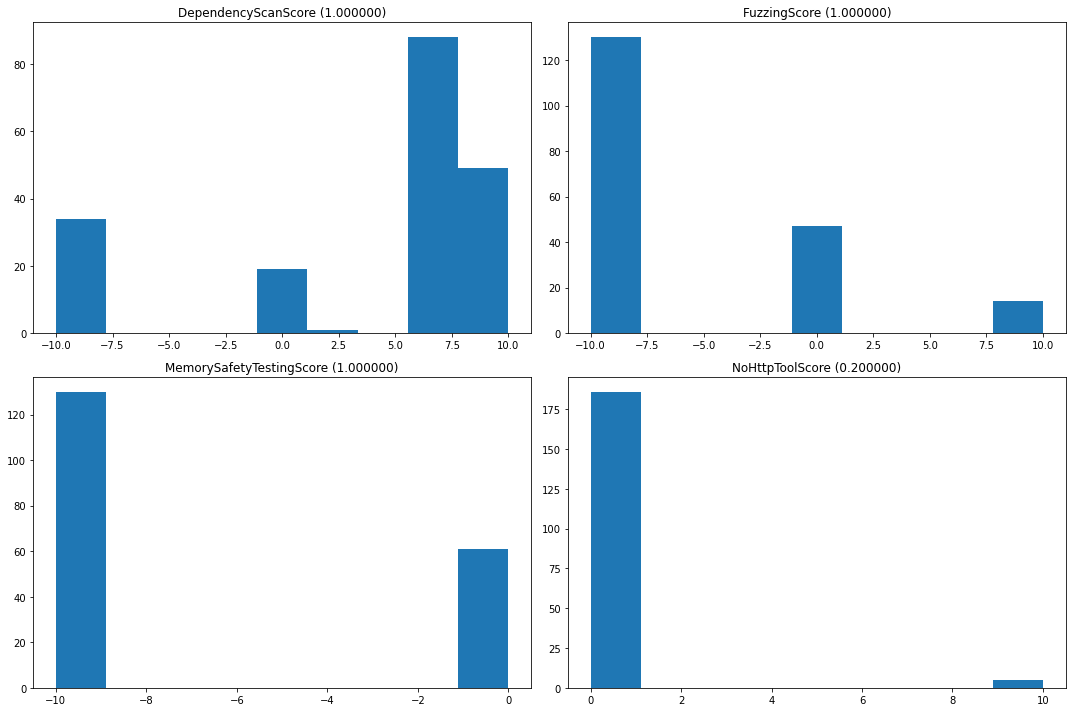

In [7]:
df = project_data[['DependencyScanScore', 'FuzzingScore', 
                   'MemorySafetyTestingScore', 'NoHttpToolScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

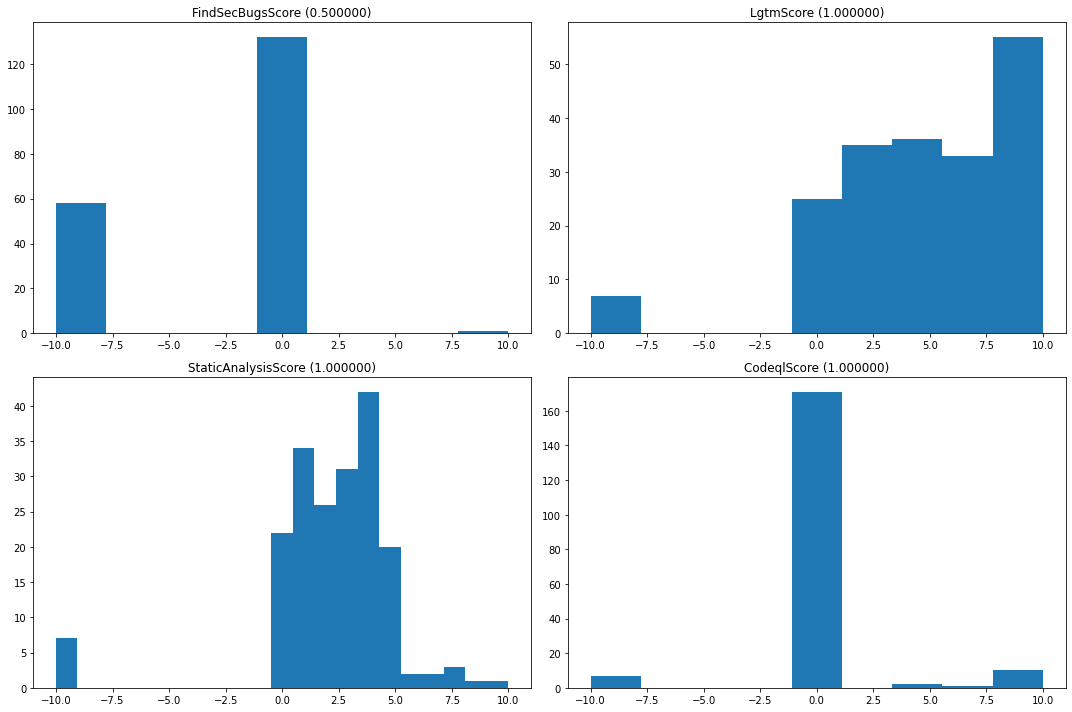

In [8]:
df = project_data[['FindSecBugsScore', 'LgtmScore', 'StaticAnalysisScore', 'CodeqlScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

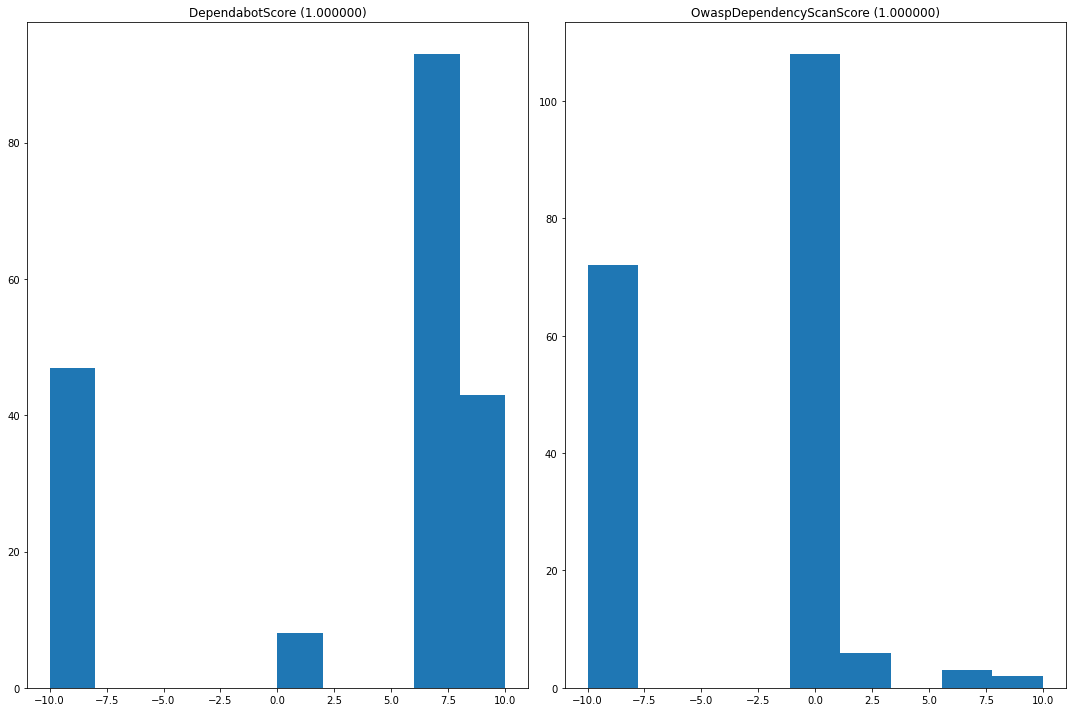

In [9]:
df = project_data[['DependabotScore', 'OwaspDependencyScanScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 2)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

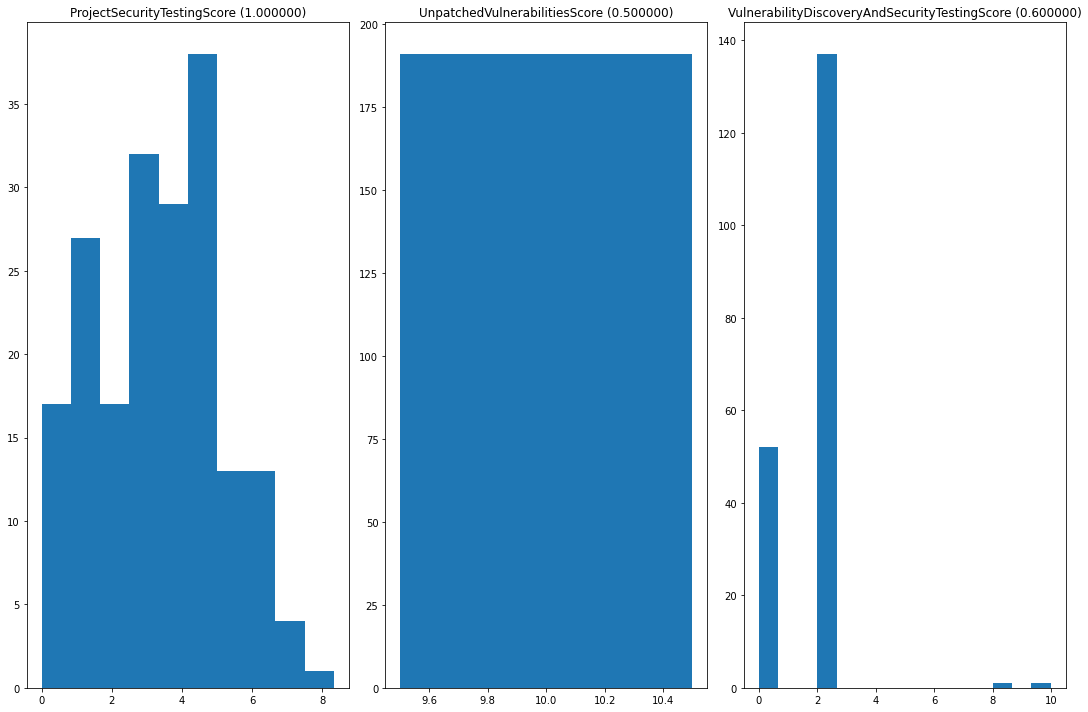

In [10]:
df = project_data[['ProjectSecurityTestingScore', 'UnpatchedVulnerabilitiesScore', 
                   'VulnerabilityDiscoveryAndSecurityTestingScore']]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(1, 3)
f.set_figwidth(15)
f.set_figheight(10)
a = a.ravel()
for idx, ax in enumerate(a):
    if idx == len(df.columns): break
    column = df.columns[idx]
    d = df[column]
    d = d.replace('N/A', -10)
    ax.hist(d, histtype='bar', bins='auto')
    ax.set_title('{} ({:f})'.format(column, score_weights[column]))
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

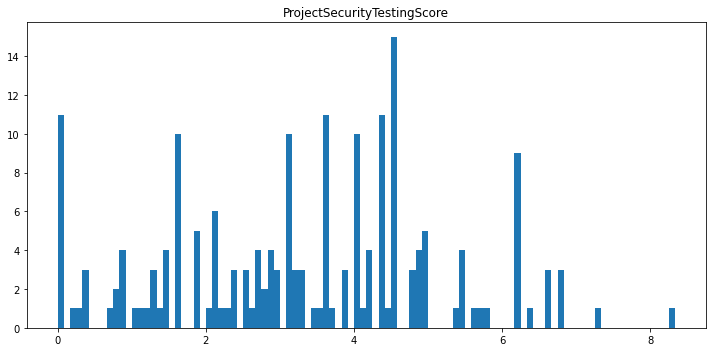

In [11]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'ProjectSecurityTestingScore'
d = df[column]
ax.hist(d, histtype='bar', bins=100)
ax.set_title(column)
plt.tight_layout()

<Figure size 720x720 with 0 Axes>

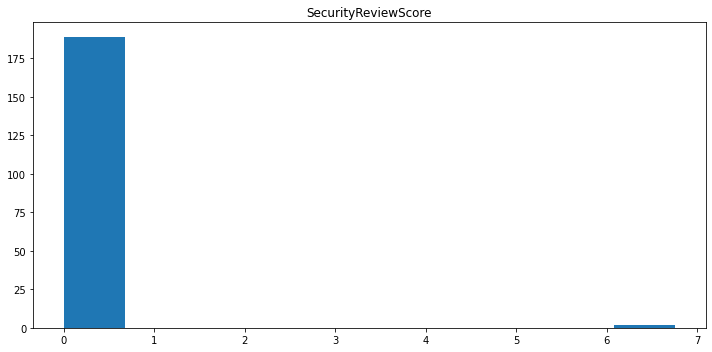

In [12]:
df = project_data
plt.figure(figsize=[10, 10])
f, ax = plt.subplots(1, 1)
f.set_figwidth(10)
f.set_figheight(5)
column = 'SecurityReviewScore'
d = df[column]
ax.hist(d, histtype='bar', bins=10)
ax.set_title(column)
plt.tight_layout()

In [13]:
pd.DataFrame.from_dict(score_weights, orient='index')

,0
VulnerabilityDiscoveryAndSecurityTestingScore,0.6
ProjectSecurityTestingScore,1.0
DependencyScanScore,1.0
DependabotScore,1.0
OwaspDependencyScanScore,1.0
StaticAnalysisScore,1.0
LgtmScore,1.0
FindSecBugsScore,0.5
CodeqlScore,1.0
NoHttpToolScore,0.2


In [14]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of unpatched vulnerabilities', 
     '# of patched vulnerabilities']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of unpatched vulnerabilities,# of patched vulnerabilities
169,https://github.com/openssl/openssl,224,0,224
89,https://github.com/apache/tomcat,192,0,192
84,https://github.com/apache/struts,81,0,81
128,https://github.com/curl/curl,78,0,78
2,https://github.com/FasterXML/jackson-databind,64,0,64
141,https://github.com/envoyproxy/envoy,42,0,42
90,https://github.com/apache/trafficserver,41,0,41
180,https://github.com/spring-projects/spring-fram...,33,0,33
4,https://github.com/apache/activemq,32,0,32
39,https://github.com/apache/hadoop,29,0,29


In [15]:
project_data[
    ['URL', 
     '# of vulnerabilities', 
     '# of vulnerabilities without introduced date', 
     '# of vulnerabilities without fixed date']
][project_data['# of vulnerabilities'] > 3].sort_values(by = '# of vulnerabilities', ascending=False)

,URL,# of vulnerabilities,# of vulnerabilities without introduced date,# of vulnerabilities without fixed date
169,https://github.com/openssl/openssl,224,224,224
89,https://github.com/apache/tomcat,192,192,192
84,https://github.com/apache/struts,81,81,81
128,https://github.com/curl/curl,78,78,78
2,https://github.com/FasterXML/jackson-databind,64,64,64
141,https://github.com/envoyproxy/envoy,42,42,42
90,https://github.com/apache/trafficserver,41,41,41
180,https://github.com/spring-projects/spring-fram...,33,33,33
4,https://github.com/apache/activemq,32,32,32
39,https://github.com/apache/hadoop,29,29,29


In [16]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def draw_boolean_hists(df, columns, a):
    a = a.ravel()
    for idx, ax in enumerate(a):
        if idx == len(df.columns): break
        column = df.columns[idx]
        if column not in columns: continue
        vc = df[column].replace(True, 'Yes').replace(False, 'No').value_counts().to_dict()
        if 'Yes' not in vc: vc['Yes'] = 0
        if 'No' not in vc: vc['No'] = 0
        if 'unknown' not in vc: vc['unknown'] = 0
        rects = ax.bar(vc.keys(), vc.values(), width=0.5)
        autolabel(rects)
        ax.set_title(column)

<Figure size 720x720 with 0 Axes>

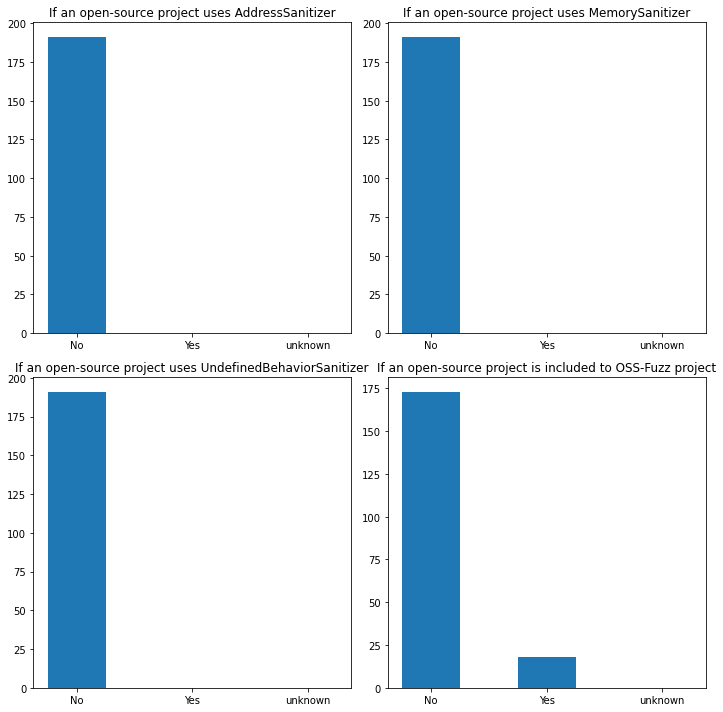

In [17]:
columns = [
    'If an open-source project uses AddressSanitizer', 
    'If an open-source project uses MemorySanitizer',
    'If an open-source project uses UndefinedBehaviorSanitizer',
    'If an open-source project is included to OSS-Fuzz project',
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(2, 2)
f.set_figwidth(10)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

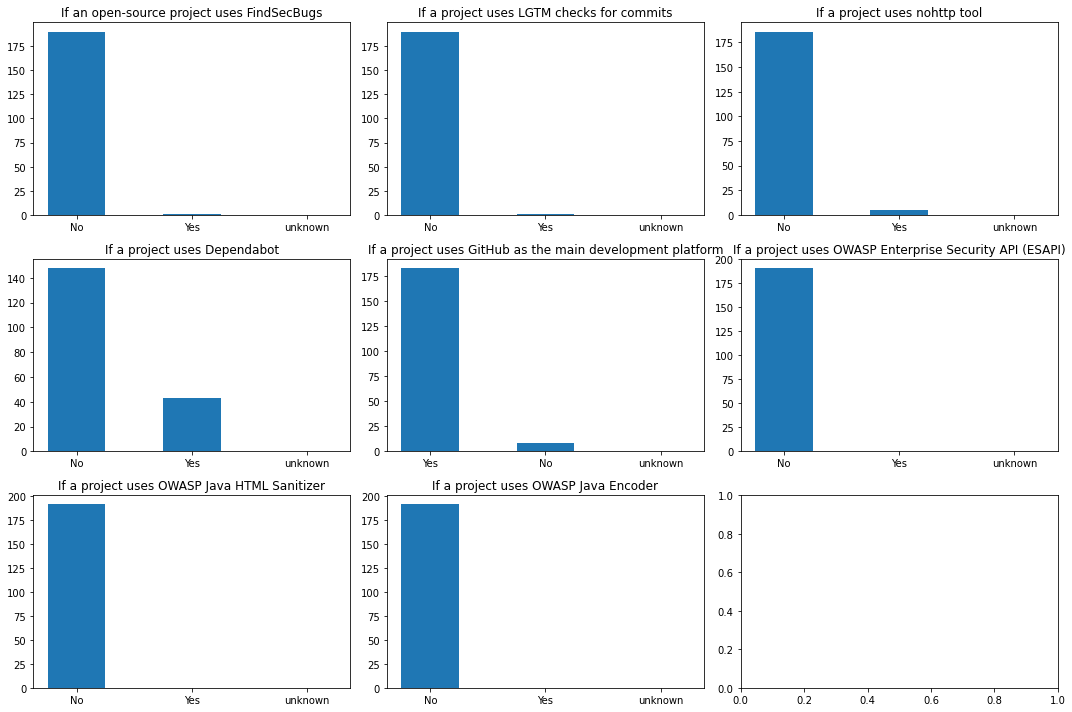

In [18]:
columns = [    
    'If an open-source project uses FindSecBugs',
    'If a project uses LGTM checks for commits',
    'If a project uses nohttp tool',
    'If a project uses Dependabot',
    'If a project uses GitHub as the main development platform',
    'If a project uses OWASP Enterprise Security API (ESAPI)',
    'If a project uses OWASP Java HTML Sanitizer',
    'If a project uses OWASP Java Encoder'
]
df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

<Figure size 720x720 with 0 Axes>

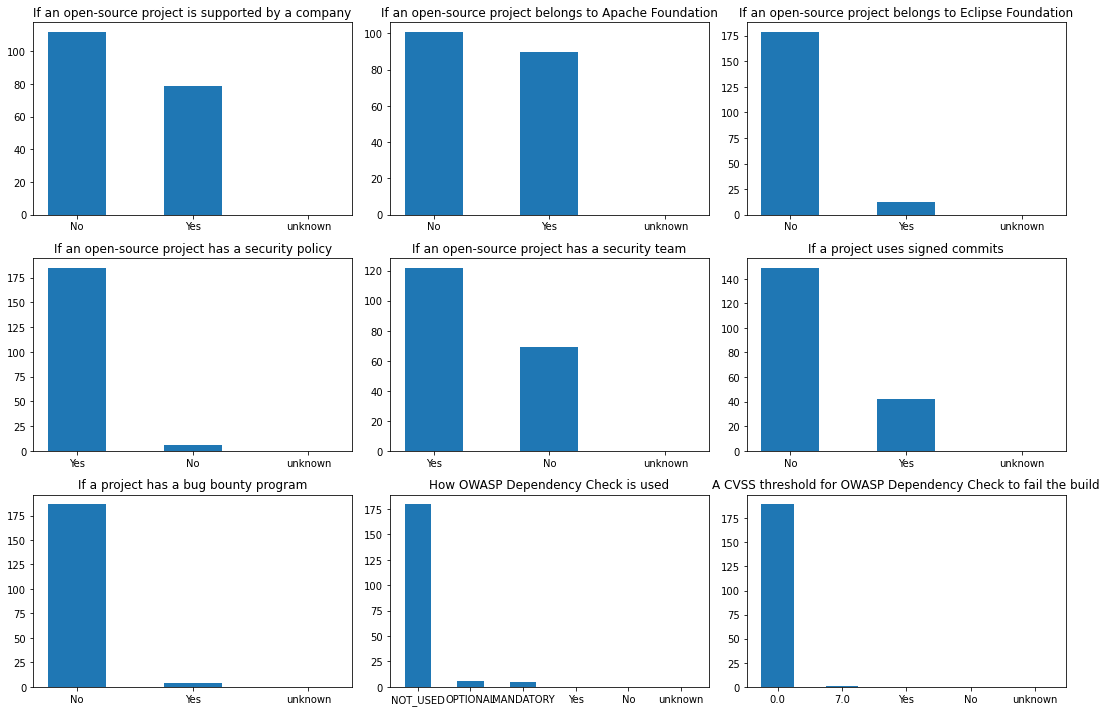

In [19]:
columns = [        
    'If an open-source project is supported by a company',
    'If an open-source project belongs to Apache Foundation',
    'If an open-source project belongs to Eclipse Foundation',
    'If an open-source project has a security policy',
    'If an open-source project has a security team',
    'If a project uses signed commits',
    'If a project has a bug bounty program',
    'How OWASP Dependency Check is used',
    'A CVSS threshold for OWASP Dependency Check to fail the build'
]

df = project_data[columns]
plt.figure(figsize=[10, 10])
f, a = plt.subplots(3, 3)
f.set_figwidth(15)
f.set_figheight(10)
draw_boolean_hists(df, columns, a)
f.tight_layout()

In [20]:
unclear_threshold = 8.0

# target ratio for bad/moderate/good ratings
bad_ratings_fraction = 0.30
moderate_ratings_fraction = 0.50
good_ratings_fraction = 0.20

if bad_ratings_fraction + moderate_ratings_fraction + good_ratings_fraction != 1:
    raise Exception('Oops! Target ratio doesn not look correct!')

n = len(project_data.index)
target_bad_ratings_number = (int) (bad_ratings_fraction * n)
target_moderate_ratings_number = (int) (moderate_ratings_fraction * n)
target_good_ratings_number = n - target_bad_ratings_number - target_moderate_ratings_number

print('Total number of projects                           = {:d}'.format(n))
print('Target number of projects with bad ragings         = {:d}'.format(target_bad_ratings_number))
print('Target number of projects with moderate ragings    = {:d}'.format(target_moderate_ratings_number))
print('Target number of projects with good ratings        = {:d}'.format(target_good_ratings_number))
    
moderate_threshold = 0
good_threshold = 0
i = 0
for index, value in project_data['Score'].sort_values().items():
    if moderate_threshold == 0 and i >= target_bad_ratings_number:
        moderate_threshold = value
        i = 0
    if good_threshold == 0 and i >= target_moderate_ratings_number:
        good_threshold = value
        break
    i = i + 1

bad_rating_number = 0
moderate_rating_number = 0
good_rating_number = 0
total = 0
for index, value in project_data['Score'].sort_values().items():
    total = total + 1
    if value > good_threshold:
        good_rating_number = good_rating_number + 1
    elif value > moderate_threshold:
        moderate_rating_number = moderate_rating_number + 1
    else:
        bad_rating_number = bad_rating_number + 1
        
actual_bad_ratings_fraction = bad_rating_number / n
actual_moderate_ratings_fraction = moderate_rating_number / n
actual_good_ratings_fraction = good_rating_number / n
        
print('New threshold for MODERATE        = {:f}'.format(moderate_threshold))
print('New threshold for GOOD            = {:f}'.format(good_threshold))
print('Expected bad rating fraction      = {:f}'.format(bad_ratings_fraction))
print('Actual bad rating fraction        = {:f}'.format(actual_bad_ratings_fraction))
print('Expected moderate rating fraction = {:f}'.format(moderate_ratings_fraction))
print('Actual moderate rating fraction   = {:f}'.format(actual_moderate_ratings_fraction))
print('Expected good rating fraction     = {:f}'.format(good_ratings_fraction))
print('Actual good rating fraction       = {:f}'.format(actual_good_ratings_fraction))

if abs(actual_good_ratings_fraction - good_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for GOOD ratings!')
if abs(actual_moderate_ratings_fraction - moderate_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for MODERATE ratings!')
if abs(actual_bad_ratings_fraction - bad_ratings_fraction) > 0.01:
    print('Achtung! We did not achieve the target fraction for BAD ratings!')

Total number of projects                           = 191
Target number of projects with bad ragings         = 57
Target number of projects with moderate ragings    = 95
Target number of projects with good ratings        = 39
New threshold for MODERATE        = 4.393709
New threshold for GOOD            = 5.744681
Expected bad rating fraction      = 0.300000
Actual bad rating fraction        = 0.303665
Expected moderate rating fraction = 0.500000
Actual moderate rating fraction   = 0.507853
Expected good rating fraction     = 0.200000
Actual good rating fraction       = 0.188482
Achtung! We did not achieve the target fraction for GOOD ratings!


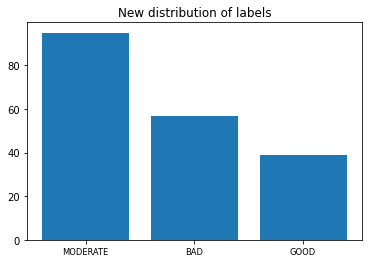

In [21]:
def get_new_label(row):
    s = row['Score']
    c = row['Confidence']
    if c < unclear_threshold: return 'UNCLEAR'
    if s >= good_threshold: return 'GOOD'
    if s >= moderate_threshold: return 'MODERATE'
    return 'BAD'

project_data['Label'] = project_data.apply(lambda row: get_new_label(row), axis=1)
df = project_data['Label'].value_counts()
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.title('New distribution of labels')
plt.show()

In [22]:
# save the new thresholds
data = {}
data['moderate'] = moderate_threshold
data['good'] = good_threshold
data['unclear'] = unclear_threshold
output_file = os.environ.get('OUTPUT_FILE', '../../../../../src/main/resources/com/sap/oss/phosphor/fosstars/model/rating/oss/OssSecurityRatingThresholds.json')
with open(output_file, 'w') as file:
    json.dump(data, file, sort_keys=True, indent=2)